# 1. Load config and variables

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os

import spacy, pickle

import torch

from torchtext import data
from torchtext import datasets

import random
import inspect

# Custom impport
from common.common_classes import TensorField

In [3]:
torch.cuda.is_available()

True

In [4]:
path = "./"
save_data_path = path + 'save_data/'
large_save_data_path = '/notebooks/large-storage/'
saved_models_path = '/notebooks/large-storage/saved-models/'
print(os.listdir(path))

['test.tsv', 'GRU-with-attention-implement.ipynb', 'LSTM-with-attention-implement.ipynb', 'prepare-word-embedding-nlp.ipynb', 'tokenization.ipynb', 'test-batching-padding.ipynb', 'train.tsv', 'test-batching-padding-ok.ipynb', 'LSTM-implement.ipynb', 'sampleSubmission.csv', 'save_data', '.ipynb_checkpoints', '__init__.py', 'README.md', '.gitignore', '.git', 'common', 'simple-GRU-implement.ipynb']


In [5]:
loaded_data = pickle.load(open(save_data_path + 'pre-processed-data.pkl', 'rb'))
loaded_kaggle_test = pickle.load(open(save_data_path + 'pre-processed-kaggle-test.pkl', 'rb'))
loaded_vocab = pickle.load(open(save_data_path + 'genereated-vocab.pkl', 'rb'))

In [6]:
loaded_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_length,Tokenized_phrase,Indexed_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,188,"[xxbos, a, series, of, escapades, demonstratin...","[2, 10, 341, 11, 14246, 6044, 8, 6604, 19, 64,..."
1,2,1,A series of escapades demonstrating the adage ...,2,77,"[xxbos, a, series, of, escapades, demonstratin...","[2, 10, 341, 11, 14246, 6044, 8, 6604, 19, 64,..."
2,3,1,A series,2,8,"[xxbos, a, series, xxeos]","[2, 10, 341, 3]"
3,4,1,A,2,1,"[xxbos, a, xxeos]","[2, 10, 3]"
4,5,1,series,2,6,"[xxbos, series, xxeos]","[2, 341, 3]"


In [7]:
loaded_kaggle_test.head()

,PhraseId,SentenceId,Phrase,Phrase_length,Tokenized_phrase,Indexed_phrase
0,156061,8545,An intermittently pleasing but mostly routine ...,188,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 15, 3]"
1,156062,8545,An intermittently pleasing but mostly routine ...,77,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 3]"
2,156063,8545,An,8,"[xxbos, xxmaj, an, xxeos]","[2, 7, 26, 3]"
3,156064,8545,intermittently pleasing but mostly routine effort,1,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 409, 3]"
4,156065,8545,intermittently pleasing but mostly routine,6,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 3]"


In [8]:
UNK, PAD, BOS, EOS, TK_REP, TK_WREP, TK_UP, TK_MAJ = "xxunk xxpad xxbos xxeos xxrep xxwrep xxup xxmaj".split()

default_spec_tok = [UNK, PAD, BOS, EOS, TK_REP, TK_WREP, TK_UP, TK_MAJ]

MAX_LABEL = 5

### Check max length of sequences

In [9]:
max_len = 0
max_index = -1
for i in range(len(loaded_data['Tokenized_phrase'])):
    if len(loaded_data['Tokenized_phrase'][i]) > max_len:
        max_len = len(loaded_data['Tokenized_phrase'][i])
        max_index = i
        
print(max_len)
print(max_index)

62
43802


In [10]:
max_len = 0
max_index = -1
for i in range(len(loaded_kaggle_test['Tokenized_phrase'])):
    if len(loaded_kaggle_test['Tokenized_phrase'][i]) > max_len:
        max_len = len(loaded_kaggle_test['Tokenized_phrase'][i])
        max_index = i
        
print(max_len)
print(max_index)

60
35146


# 2. Encoding and prepraing batches

In [11]:
nlp = spacy.load(large_save_data_path + 'process-spacy-model')

In [12]:
nlp.vocab[BOS].vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [13]:
type(nlp.vocab.get_vector('test'))

numpy.ndarray

In [14]:
nlp.vocab.vectors.data.shape

(890280, 308)

In [15]:
# For Kaggle Train dataset
PHRASE_ID = data.Field(use_vocab = False)
TEXT = TensorField(include_lengths = True, use_vocab = False, sequential = False, pad_token = nlp.vocab[PAD].vector, dtype=torch.float)
LABEL = data.LabelField(use_vocab = False, dtype=torch.long)

# For Kaggle Test dataset
ID_TEST = data.Field(use_vocab = False)
PHRASE_ID_TEST = data.Field(use_vocab = False)
TEXT_TEST = TensorField(include_lengths = True, use_vocab = False, sequential = False, pad_token = nlp.vocab[PAD].vector, dtype=torch.float)

In [16]:
# For Kaggle Train dataset
fields = [('id', PHRASE_ID), ('text', TEXT), ('label', LABEL)]

# For Kaggle Test dataset
fields_test = [('id', ID_TEST), ('phrase_id', PHRASE_ID_TEST), ('text', TEXT_TEST)]

In [17]:
len(loaded_data['Phrase'])

156060

In [18]:
len(loaded_kaggle_test['Phrase'])

66292

In [19]:
# For Kaggle Train dataset
examples = []
length = len(loaded_data['Phrase'])
for i in range(length):
    embedded = []
    for j in range(len(loaded_data['Tokenized_phrase'][i])):
        if nlp.vocab.has_vector(loaded_data['Tokenized_phrase'][i][j]):
            embedded.append(nlp.vocab.get_vector(loaded_data['Tokenized_phrase'][i][j]))
        else:
            embedded.append(nlp.vocab.get_vector(UNK))
    
    examples.append(data.Example.fromlist([ [loaded_data['PhraseId'][i]], embedded, loaded_data['Sentiment'][i]], fields))
    
examples[:10]

In [20]:
# For Kaggle Test dataset
examples_test = []
length = len(loaded_kaggle_test['Phrase'])
for i in range(length):
    embedded = []
    for j in range(len(loaded_kaggle_test['Tokenized_phrase'][i])):
        if nlp.vocab.has_vector(loaded_kaggle_test['Tokenized_phrase'][i][j]):
            embedded.append(nlp.vocab.get_vector(loaded_kaggle_test['Tokenized_phrase'][i][j]))
        else:
            embedded.append(nlp.vocab.get_vector(UNK))
    
    examples_test.append(data.Example.fromlist([ [i], [loaded_kaggle_test['PhraseId'][i]], embedded ], fields_test))
    
examples_test[:10]

In [21]:
examples[3].text

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [22]:
examples_test[3].text

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [23]:
nlp.vocab.get_vector('a')

array([ 4.3798e-02,  2.4779e-02, -2.0937e-01,  4.9745e-01,  3.6019e-01,
       -3.7503e-01, -5.2078e-02, -6.0555e-01,  3.6744e-02,  2.2085e+00,
       -2.3389e-01, -6.8360e-02, -2.2355e-01, -5.3989e-02, -1.5198e-01,
       -1.7319e-01,  5.3355e-02,  1.6485e+00, -4.7991e-02, -8.5311e-02,
       -1.5712e-01, -6.4425e-01, -3.9819e-01,  2.7800e-01,  1.5364e-01,
        3.1678e-02,  5.5414e-02,  1.5939e-02,  3.1851e-01, -5.8979e-02,
        3.8584e-02,  1.0770e-01,  1.0410e-01, -7.7346e-02,  3.7396e-01,
       -2.1482e-01,  3.8320e-01, -2.7737e-01, -1.8352e-01, -8.3838e-01,
        3.4124e-01,  5.8164e-01,  1.8543e-01, -3.1028e-01,  1.7666e-01,
       -6.9421e-02, -3.4422e-01, -1.3665e-01, -1.0823e-01,  2.3637e-01,
       -3.2923e-01,  6.1348e-01,  1.9720e-01,  8.7123e-02,  1.0785e-01,
        3.0730e-01,  1.3757e-01,  3.0809e-01,  2.4331e-01, -2.9422e-01,
       -9.8214e-03,  5.5675e-01, -4.8880e-02,  9.9468e-02,  3.0543e-01,
       -3.7597e-01, -1.9525e-01,  4.6246e-02, -3.6675e-02,  3.40

In [24]:
examples[3].label

2

In [25]:
len(examples)

156060

In [26]:
len(examples_test)

66292

In [27]:
data_set = data.Dataset(examples, fields)
data_set_test = data.Dataset(examples_test, fields_test)

In [28]:
data_set.sort_key = lambda x: len(x.text)
data_set_test.sort_key = lambda x: len(x.text)

In [29]:
SEED = 9131

In [30]:
train_data, valid_data, test_data = data_set.split([0.8, 0.1, 0.1], random_state = random.seed(SEED))

In [31]:
train_data.sort_key

<function __main__.<lambda>(x)>

In [32]:
len(data_set)*0.1

15606.0

In [33]:
len(train_data)

124848

In [34]:
len(valid_data)

15606

In [35]:
len(test_data)

15606

In [36]:
len(data_set_test)

66292

In [37]:
inspect.getsource(train_data.sort_key)

'data_set.sort_key = lambda x: len(x.text)\n'

In [38]:
inspect.getsource(data_set_test.sort_key)

'data_set_test.sort_key = lambda x: len(x.text)\n'

## Define Hyperparameter

In [39]:
BATCH_SIZE = 64

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

kaggle_test_iterator = data.BucketIterator(
    data_set_test, 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [41]:
raw_train_iterator = iter(train_iterator)
batch = next(raw_train_iterator)

raw_kaggle_test_iterator = iter(kaggle_test_iterator)
batch_test = next(raw_kaggle_test_iterator)

In [42]:
a, b = batch.text

c, d = batch_test.text

In [43]:
b

tensor([9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9., 9.,
        9., 9., 9., 9., 9., 9., 9., 9., 9., 9.], device='cuda:0')

In [44]:
a.shape

torch.Size([64, 9, 308])

In [45]:
batch.label

tensor([2, 2, 0, 2, 2, 1, 3, 3, 1, 3, 3, 2, 2, 2, 2, 2, 0, 2, 1, 4, 3, 2, 3, 2,
        2, 2, 1, 3, 1, 2, 2, 1, 3, 1, 2, 2, 1, 4, 2, 3, 2, 3, 2, 2, 1, 4, 2, 2,
        2, 3, 2, 3, 1, 2, 2, 3, 4, 2, 2, 4, 2, 2, 1, 4], device='cuda:0')

In [46]:
batch.id

tensor([[133918,  57783,  94049,  86671,  84086,  74128, 112683, 126943,  12599,
         138419,  47937,  62635, 104584,  86587, 113162,  81036,  62472, 147974,
          32209, 133654,  95241, 137072,  66415,  75555,  53039, 130485,  79837,
         152257,  39951, 136680, 121126, 102615, 101662, 119728, 108929, 145776,
          36689,  66928, 109732, 109843, 130506,  33026, 123268, 155495, 114095,
          27453, 122599,  82520,  21535, 104973,  91096,  97182,  84542, 119081,
         104435,  65401,  30863, 141808,  39997, 145932,  46149, 125167, 132902,
         117864]], device='cuda:0')

In [47]:
loaded_data['Sentiment'][117864-1]

4

In [48]:
d

tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10.], device='cuda:0')

In [49]:
c.shape

torch.Size([64, 10, 308])

In [50]:
batch_test.id.shape

torch.Size([1, 64])

In [51]:
batch_test.phrase_id.shape

torch.Size([1, 64])

In [52]:
loaded_kaggle_test.iloc[37401]

PhraseId                                                       193462
SentenceId                                                      10289
Phrase                         you 're not into the Pokemon franchise
Phrase_length                                                      72
Tokenized_phrase    [xxbos, you, 're, not, into, the, xxmaj, pokem...
Indexed_phrase               [2, 33, 157, 41, 61, 8, 7, 2893, 978, 3]
Name: 37401, dtype: object

In [53]:
c[63][2]

tensor([-1.2598e-01,  2.3681e-01, -3.0048e-01, -3.4822e-02,  1.4940e-01,
        -3.6147e-02, -2.9160e-02,  4.2446e-02, -1.4922e-02,  2.4803e+00,
         1.3138e-01,  1.8270e-01,  1.9732e-01, -1.1765e-01, -1.9910e-01,
        -9.9976e-02, -1.3003e-02,  8.6874e-01, -2.5387e-01, -4.7935e-02,
         6.2166e-02, -6.8214e-02,  9.0818e-02,  1.8553e-01, -4.6234e-01,
        -7.4295e-02, -1.1136e-01, -1.7341e-01,  6.2637e-01, -5.4815e-01,
        -2.3186e-01,  2.1671e-01,  2.3657e-01,  3.4814e-03,  2.1973e-01,
         8.1694e-02,  7.2784e-02,  3.2418e-01,  1.8485e-01, -7.8116e-02,
        -1.0398e-01,  2.5184e-01, -3.2611e-01,  2.1050e-01,  1.7217e-01,
         1.4633e-01, -2.4610e-01, -1.2313e-01,  1.8549e-02, -1.7679e-01,
         5.4608e-02,  1.9721e-02, -1.4351e-01, -9.8868e-02,  1.9156e-01,
        -1.8175e-01, -9.6741e-03, -2.8860e-01,  3.2727e-01,  8.7877e-02,
         1.5791e-01, -5.9451e-01, -4.0692e-01,  1.0203e-01,  2.0662e-01,
        -3.0393e-01, -1.7494e-01,  1.6815e-01,  1.3

In [54]:
nlp.vocab.get_vector("'re")

array([-1.2598e-01,  2.3681e-01, -3.0048e-01, -3.4822e-02,  1.4940e-01,
       -3.6147e-02, -2.9160e-02,  4.2446e-02, -1.4922e-02,  2.4803e+00,
        1.3138e-01,  1.8270e-01,  1.9732e-01, -1.1765e-01, -1.9910e-01,
       -9.9976e-02, -1.3003e-02,  8.6874e-01, -2.5387e-01, -4.7935e-02,
        6.2166e-02, -6.8214e-02,  9.0818e-02,  1.8553e-01, -4.6234e-01,
       -7.4295e-02, -1.1136e-01, -1.7341e-01,  6.2637e-01, -5.4815e-01,
       -2.3186e-01,  2.1671e-01,  2.3657e-01,  3.4814e-03,  2.1973e-01,
        8.1694e-02,  7.2784e-02,  3.2418e-01,  1.8485e-01, -7.8116e-02,
       -1.0398e-01,  2.5184e-01, -3.2611e-01,  2.1050e-01,  1.7217e-01,
        1.4633e-01, -2.4610e-01, -1.2313e-01,  1.8549e-02, -1.7679e-01,
        5.4608e-02,  1.9721e-02, -1.4351e-01, -9.8868e-02,  1.9156e-01,
       -1.8175e-01, -9.6741e-03, -2.8860e-01,  3.2727e-01,  8.7877e-02,
        1.5791e-01, -5.9451e-01, -4.0692e-01,  1.0203e-01,  2.0662e-01,
       -3.0393e-01, -1.7494e-01,  1.6815e-01,  1.3331e-01,  2.05

In [55]:
torch.cuda.is_available()

True

## Define model

In [56]:
import torch.nn as nn

class GRUWithAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, context_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()
        
        self.rnn = nn.GRU( embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional,
                           batch_first=True,
                           dropout=dropout)
        
        self.bidirectional = bidirectional
        
        if bidirectional:
            ## Word-level hierarchical attention:
            self.ui = nn.Linear(2*hidden_dim, context_dim)
            self.uw = nn.Parameter(torch.randn(context_dim))
            
            self.fc = nn.Linear(hidden_dim * 2, output_dim)
        else:
            ## Word-level hierarchical attention:
            self.ui = nn.Linear(hidden_dim, context_dim)
            self.uw = nn.Parameter(torch.randn(context_d))
            
            self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size, sent len, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(text, text_lengths, batch_first=True)
        
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        #output = [batch size, senq len, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        if self.bidirectional:
            ## Word-level hierarchical attention:
            u_it = torch.tanh(self.ui(output)) # Batch size X senq len X context dim
            weights = torch.softmax(u_it.matmul(self.uw), dim=1).unsqueeze(1)
            
            hidden = torch.sum(weights.matmul(output), dim=1) # Batch size X Hidden dim*2

            hidden = self.dropout(hidden)
        else:
            u_it = torch.tanh(self.ui(output)) # Batch size X senq len X context dim
            weights = torch.softmax(u_it.matmul(self.uw), dim=1).unsqueeze(1)
            
            hidden = torch.sum(weights.matmul(output), dim=1) # Batch size X Hidden dim

            hidden = self.dropout(hidden)
        
        #if self.bidirectional:
        #    hidden = [batch size, hid dim * num directions]
        #else:
        #    hidden = [batch size, hid dim]
        
        # with RELU
        #return self.fc(self.relu(hidden))
        
        return self.fc(hidden)

## Define Hyperparameter and init model

In [57]:
EMBEDDING_DIM = 308
HIDDEN_DIM = 256
CONTEXT_DIM = 70
OUTPUT_DIM = 5
N_LAYERS = 2
BIDIRECTIONAL = True

# Regularization hyperparameter
DROPOUT = 0.55
L2_LAMBDA = 0 #0.00001

LEARNING_RATE = 0.0005

N_EPOCHS = 100

MODEL_SAVE_FILE = 'GRU_with_attention_origin.pt'
model = GRUWithAttention(EMBEDDING_DIM, 
            HIDDEN_DIM, 
            CONTEXT_DIM,
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT).to(device)

### Print out the number of parameters in our model.

In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,090,641 trainable parameters


## Train the Model

In [59]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

In [60]:
criterion = torch.nn.CrossEntropyLoss().to(device)

### Train function

In [61]:
def train(model, iterator, optimizer, criterion, set_length):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths)
        loss = criterion(predictions, batch.label)
        
        epoch_acc += (predictions.argmax(1) == batch.label).sum().item()
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / set_length, epoch_acc / set_length

### Evaluate function

In [62]:
def evaluate(model, iterator, criterion, set_length):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += (predictions.argmax(1) == batch.label).sum().item()
        
    return epoch_loss / set_length, epoch_acc / set_length

### Define epoch time function

In [63]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [64]:
# best_valid_loss = float('inf')
best_valid_acc = 0
best_epoch = 0

# For splotting
all_train_losses = []
all_valid_losses = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, len(train_data))
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, len(valid_data))
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     if valid_loss < best_valid_loss:
    if valid_acc > best_valid_acc:
#         best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model.state_dict(), saved_models_path + MODEL_SAVE_FILE)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)
    
print(f'Best epoch: {best_epoch+1:02}')

Epoch: 01 | Epoch Time: 0m 57s
	Train Loss: 0.01439 | Train Acc: 61.80%
	 Val. Loss: 0.01359 |  Val. Acc: 63.92%
Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 0.01316 | Train Acc: 64.76%
	 Val. Loss: 0.01270 |  Val. Acc: 66.25%
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 0.01243 | Train Acc: 66.71%
	 Val. Loss: 0.01231 |  Val. Acc: 67.38%
Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 0.01181 | Train Acc: 68.48%
	 Val. Loss: 0.01199 |  Val. Acc: 68.42%
Epoch: 05 | Epoch Time: 0m 58s
	Train Loss: 0.01125 | Train Acc: 69.91%
	 Val. Loss: 0.01184 |  Val. Acc: 68.80%
Epoch: 06 | Epoch Time: 0m 58s
	Train Loss: 0.01079 | Train Acc: 71.25%
	 Val. Loss: 0.01205 |  Val. Acc: 68.55%
Epoch: 07 | Epoch Time: 0m 58s
	Train Loss: 0.01036 | Train Acc: 72.42%
	 Val. Loss: 0.01174 |  Val. Acc: 69.17%
Epoch: 08 | Epoch Time: 0m 57s
	Train Loss: 0.00998 | Train Acc: 73.43%
	 Val. Loss: 0.01175 |  Val. Acc: 69.64%
Epoch: 09 | Epoch Time: 0m 58s
	Train Loss: 0.00961 | Train Acc: 74.62%
	 Val. Loss: 0.01174 |  

KeyboardInterrupt: 

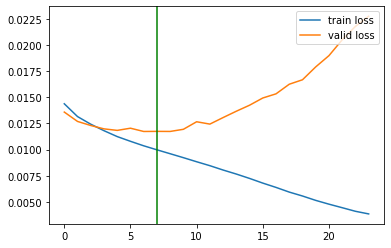

In [65]:
import matplotlib.pyplot as plt

plt.figure()
# plt.xticks(range(0, 10))
plt.plot(all_train_losses)
plt.plot(all_valid_losses)
plt.axvline(x=best_epoch, color='green')

plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

In [66]:
len(test_data)

15606

In [66]:
print(f'Best epoch: {best_epoch+1:02}')

Best epoch: 08


## Test the Model

In [67]:
model.load_state_dict(torch.load(saved_models_path + MODEL_SAVE_FILE))

test_loss, test_acc = evaluate(model, test_iterator, criterion, len(test_data))

print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.01186 | Test Acc: 69.33%


### Reevaluate on valid set

In [68]:
model.load_state_dict(torch.load(saved_models_path + MODEL_SAVE_FILE))

valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, len(valid_data))

print(f'Test Loss: {valid_loss:.5f} | Test Acc: {valid_acc*100:.2f}%')

Test Loss: 0.01175 | Test Acc: 69.64%


## Test on Kaggle Dataset and create submittion file

In [69]:
# Change the model target file
MODEL_SAVE_FILE_TARGET = 'GRU_with_attention_train-73.43-valid-69.64.pt'

def predict_kaggle_test(model, iterator):
    
    result = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths)
            
            predictions = predictions.argmax(1)
            
            for i in range(len(batch)):
                result.append([batch.id[0][i].item(), [batch.phrase_id[0][i].item(), predictions[i].item()]] )
    
    result.sort(key = lambda val: val[0])
        
    return result

In [70]:
model.load_state_dict(torch.load(saved_models_path + MODEL_SAVE_FILE_TARGET))

kaggle_result_list = predict_kaggle_test(model, kaggle_test_iterator)

kaggle_result_list[:10]

[[0, [156061, 2]],
 [1, [156062, 2]],
 [2, [156063, 2]],
 [3, [156064, 2]],
 [4, [156065, 2]],
 [5, [156066, 2]],
 [6, [156067, 3]],
 [7, [156068, 2]],
 [8, [156069, 3]],
 [9, [156070, 2]]]

In [71]:
kaggle_result_list[-10:]

[[66282, [222343, 2]],
 [66283, [222344, 2]],
 [66284, [222345, 2]],
 [66285, [222346, 2]],
 [66286, [222347, 2]],
 [66287, [222348, 0]],
 [66288, [222349, 0]],
 [66289, [222350, 1]],
 [66290, [222351, 1]],
 [66291, [222352, 1]]]

In [72]:
len(kaggle_result_list)

66292

In [73]:
loaded_kaggle_test.head(10)

,PhraseId,SentenceId,Phrase,Phrase_length,Tokenized_phrase,Indexed_phrase
0,156061,8545,An intermittently pleasing but mostly routine ...,188,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 15, 3]"
1,156062,8545,An intermittently pleasing but mostly routine ...,77,"[xxbos, xxmaj, an, intermittently, pleasing, b...","[2, 7, 26, 2606, 1723, 30, 632, 1041, 409, 3]"
2,156063,8545,An,8,"[xxbos, xxmaj, an, xxeos]","[2, 7, 26, 3]"
3,156064,8545,intermittently pleasing but mostly routine effort,1,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 409, 3]"
4,156065,8545,intermittently pleasing but mostly routine,6,"[xxbos, intermittently, pleasing, but, mostly,...","[2, 2606, 1723, 30, 632, 1041, 3]"
5,156066,8545,intermittently pleasing but,68,"[xxbos, intermittently, pleasing, but, xxeos]","[2, 2606, 1723, 30, 3]"
6,156067,8545,intermittently pleasing,2,"[xxbos, intermittently, pleasing, xxeos]","[2, 2606, 1723, 3]"
7,156068,8545,intermittently,65,"[xxbos, intermittently, xxeos]","[2, 2606, 3]"
8,156069,8545,pleasing,9,"[xxbos, pleasing, xxeos]","[2, 1723, 3]"
9,156070,8545,but,55,"[xxbos, but, xxeos]","[2, 30, 3]"


### Write into CSV Files

In [74]:
CSV_EXTENSION = '.submit.csv'

import csv

with open(saved_models_path + MODEL_SAVE_FILE_TARGET + CSV_EXTENSION, mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    csv_writer.writerow(['PhraseId', 'Sentiment'])
    
    for i in range(len(kaggle_result_list)):
        csv_writer.writerow(kaggle_result_list[i][1])